In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files  # Import Colab file upload library

# Upload files directly from your device
uploaded = files.upload()  # This opens a file upload dialog

# Load the uploaded CSV files
train_data = pd.read_csv("Fetus_trainingdata.csv")
test_data = pd.read_csv("Fetus_testingdata.csv")

Saving Fetus_testingdata.csv to Fetus_testingdata (3).csv
Saving Fetus_trainingdata.csv to Fetus_trainingdata (3).csv


In [ ]:
# Load data
train_data = pd.read_csv("Fetus_trainingdata.csv")
test_data = pd.read_csv("Fetus_testingdata.csv")

# Separate features and labels
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Convert categorical labels to numeric codes
train_data['label_encoded'] = pd.Categorical(train_data.iloc[:, 0]).codes
test_data['label_encoded'] = pd.Categorical(test_data.iloc[:, 0],
                                            categories=pd.Categorical(train_data.iloc[:, 0]).categories).codes

# Separate features and encoded labels
X_train = train_data.iloc[:, 1:-1].values  # Features
y_train = train_data['label_encoded'].values  # Encoded labels
X_test = test_data.iloc[:, 1:-1].values
y_test = test_data['label_encoded'].values


In [ ]:
class FetusDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create Dataset and DataLoader instances
batch_size = 32
train_dataset = FetusDataset(X_train, y_train)
test_dataset = FetusDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(16, 10)
        self.fc2 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(10)
        #self.batchnorm2 = nn.BatchNorm1d(5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.fc2(x)  # No softmax here; CrossEntropyLoss will handle it
        return x

# Instantiate the model
model = MLPModel()


In [ ]:
#Set hyperparameters
learning_rate = 0.0001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)


In [ ]:
# Initialize lists for tracking metrics
num_epochs = 10000
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    correct_train, total_train = 0, 0
    train_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    correct_test, total_test = 0, 0
    test_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct_test / total_test)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")


Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Train Loss: 0.6232, Train Acc: 63.01%, Test Loss: 0.5637, Test Acc: 70.69%
Epoch 5002/10000, Train Loss: 0.6172, Train Acc: 65.32%, Test Loss: 0.5586, Test Acc: 72.41%
Epoch 5003/10000, Train Loss: 0.6260, Train Acc: 66.18%, Test Loss: 0.5551, Test Acc: 74.14%
Epoch 5004/10000, Train Loss: 0.6340, Train Acc: 60.69%, Test Loss: 0.5562, Test Acc: 75.86%
Epoch 5005/10000, Train Loss: 0.6256, Train Acc: 61.27%, Test Loss: 0.5563, Test Acc: 74.14%
Epoch 5006/10000, Train Loss: 0.6178, Train Acc: 64.74%, Test Loss: 0.5543, Test Acc: 74.14%
Epoch 5007/10000, Train Loss: 0.6115, Train Acc: 63.87%, Test Loss: 0.5525, Test Acc: 74.14%
Epoch 5008/10000, Train Loss: 0.6229, Train Acc: 64.74%, Test Loss: 0.5539, Test Acc: 70.69%
Epoch 5009/10000, Train Loss: 0.6017, Train Acc: 65.32%, Test Loss: 0.5563, Test Acc: 72.41%
Epoch 5010/10000, Train Loss: 0.6194, Train Acc: 63.01%, Test Loss: 0.5541, Test Acc: 72.41%
Epoch 5011/10000, T

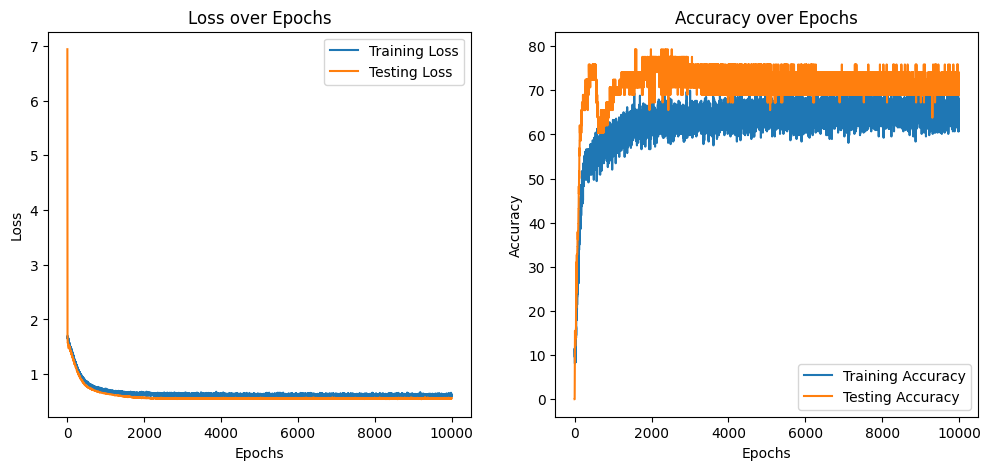

In [ ]:
# Plot loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


In [ ]:
import itertools

# Define ranges for hyperparameters
learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [16, 32, 64]
hidden_layer_sizes = [(10,), (20,), (10, 5)]  # List of tuples representing each layer's units
num_epochs = 50  # Set a standard number of epochs for each run

best_accuracy = 0
best_params = {}

for lr, batch_size, hidden_sizes in itertools.product(learning_rates, batch_sizes, hidden_layer_sizes):
    print(f"Testing configuration: Learning Rate={lr}, Batch Size={batch_size}, Hidden Sizes={hidden_sizes}")

    # Define a new model class each time to avoid reusing the same weights
    class MLPModel(nn.Module):
        def __init__(self):
            super(MLPModel, self).__init__()
            layers = [nn.Linear(16, hidden_sizes[0]), nn.ReLU()]
            if len(hidden_sizes) > 1:
                layers.extend([nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.ReLU()])
            layers.append(nn.Linear(hidden_sizes[-1], 5))  # Output layer
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    model = MLPModel()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Create new DataLoader instances for the current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Testing accuracy: {accuracy:.2f}%\n")

    # Check if this configuration is the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'hidden_sizes': hidden_sizes}

print(f"Best Testing Accuracy: {best_accuracy:.2f}% with parameters {best_params}")


Testing configuration: Learning Rate=0.001, Batch Size=16, Hidden Sizes=(10,)
Testing accuracy: 60.34%

Testing configuration: Learning Rate=0.001, Batch Size=16, Hidden Sizes=(20,)
Testing accuracy: 53.45%

Testing configuration: Learning Rate=0.001, Batch Size=16, Hidden Sizes=(10, 5)
Testing accuracy: 55.17%

Testing configuration: Learning Rate=0.001, Batch Size=32, Hidden Sizes=(10,)
Testing accuracy: 58.62%

Testing configuration: Learning Rate=0.001, Batch Size=32, Hidden Sizes=(20,)
Testing accuracy: 63.79%

Testing configuration: Learning Rate=0.001, Batch Size=32, Hidden Sizes=(10, 5)
Testing accuracy: 51.72%

Testing configuration: Learning Rate=0.001, Batch Size=64, Hidden Sizes=(10,)
Testing accuracy: 37.93%

Testing configuration: Learning Rate=0.001, Batch Size=64, Hidden Sizes=(20,)
Testing accuracy: 65.52%

Testing configuration: Learning Rate=0.001, Batch Size=64, Hidden Sizes=(10, 5)
Testing accuracy: 50.00%

Testing configuration: Learning Rate=0.005, Batch Size=16,